# GR5243 Group Project
##### Xingchen Ji, Yuting Wang, Hongyi Xu, and Jiacan Zhou

### Part 1. Data Collection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
eta = pd.read_csv("../Data/RTA.csv")

### Part 2. Data Cleaning and Data Preprocessing

##### (a) Handling Missing Data and Invalid Variables

[Text(0.5, 1.0, 'Histogram of Accident Severity'),
 Text(0.5, 0, 'Accident Severity')]

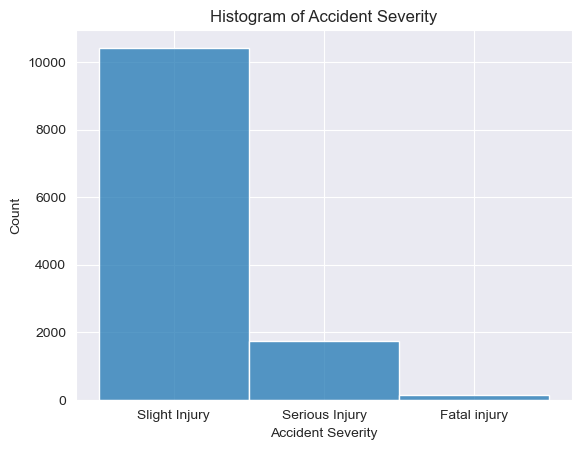

In [3]:
eta["Accident_severity"].value_counts()
sns.histplot(eta["Accident_severity"]).set(title = "Histogram of Accident Severity", xlabel = "Accident Severity")

In [4]:
eta.drop(["Service_year_of_vehicle", "Defect_of_vehicle", "Work_of_casuality", "Fitness_of_casuality"], axis = 1, inplace = True)
eta.drop(["Time", "Weather_conditions", "Casualty_class", "Sex_of_casualty", "Age_band_of_casualty", "Casualty_severity"], axis = 1, inplace = True)

In [5]:
categorical = [col for col in eta.columns]
categorical.remove("Number_of_vehicles_involved")
categorical.remove("Number_of_casualties")
categorical.remove("Accident_severity")
numerical = ["Number_of_vehicles_involved", "Number_of_casualties"]

In [6]:
eta.dropna(subset = categorical, inplace = True)

##### (b) Data Transformation

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
eta_fs = eta.copy()
eta_fs[numerical] = scaler.fit_transform(eta_fs[numerical])
y_cgan = eta_fs["Accident_severity"]
y_cgan = pd.get_dummies(y_cgan, columns = ["Accident_severity"])
y = y_cgan.to_numpy(dtype = np.float32)
X_cgan = pd.get_dummies(eta_fs, columns = categorical)
X_cgan = X_cgan.drop("Accident_severity", axis = 1)
X = X_cgan.to_numpy(dtype = np.float32)

##### (c) Data Augmentation by CGAN

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skopt import gp_minimize
from skopt.space import Real, Integer

class NumericalDGenerator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim, hidden_dim):
        super(NumericalDGenerator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(noise_dim + label_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim = 1)
        return self.layers(x)

class CategoricalGenerator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim, hidden_dim):
        super(CategoricalGenerator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(noise_dim + label_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim = 1)
        return self.layers(x)

class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, num_output_numerical, num_output_categorical, hidden_dim):
        super(Generator, self).__init__()
        self.numerical_gen = NumericalDGenerator(noise_dim, label_dim, num_output_numerical, hidden_dim)
        self.categorical_gen = CategoricalGenerator(noise_dim, label_dim, num_output_categorical, hidden_dim)

    def forward(self, noise, labels):
        numerical_data = self.numerical_gen(noise, labels)
        categorical_data = self.categorical_gen(noise, labels)
        return torch.cat([numerical_data, categorical_data], dim = 1)

class NumericalDiscriminator(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim):
        super(NumericalDiscriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim + label_dim, hidden_dim),
            nn.ReLU()
        )
    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim = 1)
        return self.layers(x)

class CategoricalDiscriminator(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim):
        super(CategoricalDiscriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim + label_dim, hidden_dim),
            nn.ReLU()
        )
    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim = 1)
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self, label_dim, num_input_numerical, num_input_categorical, hidden_dim):
        super(Discriminator, self).__init__()
        self.num_input_numerical = num_input_numerical
        self.numerical_disc = NumericalDiscriminator(num_input_numerical, label_dim, hidden_dim)
        self.categorical_disc = CategoricalDiscriminator(num_input_categorical, label_dim, hidden_dim)
        self.final_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, data, labels):
        numerical_data, categorical_data = data[:, :self.num_input_numerical], data[:, self.num_input_numerical:]
        numerical_fetaure = self.numerical_disc(numerical_data, labels)
        categorical_feature = self.categorical_disc(categorical_data, labels)
        features = torch.cat([numerical_fetaure, categorical_feature], dim = 1)
        return self.final_layer(features)

def train_cgan(generator, discriminator, train_loader, device, gen_opt, disc_opt, num_epochs, noise_dim):
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        for i, (real_data, labels) in enumerate(train_loader):
            real_data, labels = real_data.to(device), labels.to(device)
            batch_size = real_data.size(0)

            disc_opt.zero_grad()
            noise = torch.randn(batch_size, noise_dim, device = device)
            fake_data = generator(noise, labels.to(device))
            real_output = discriminator(real_data, labels.to(device))
            fake_output = discriminator(fake_data.detach(), labels.to(device))
            d_loss = criterion(real_output, torch.ones_like(real_output)) + criterion(fake_output, torch.zeros_like(fake_output))
            d_loss.backward()
            disc_opt.step()

            gen_opt.zero_grad()
            fake_output = discriminator(fake_data, labels.to(device))
            g_loss = criterion(fake_output, torch.ones_like(fake_output))
            g_loss.backward()
            gen_opt.step()
        print(f"Epoch: {epoch+1}/{num_epochs}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")
    return g_loss.item()

def bayesian_optimization_cgan(train_loader, device, noise_dim, label_dim, num_numerical, num_categorical):
    def objective(params):
        num_epochs, gen_hidden_dim, disc_hidden_dim, gen_lr, disc_lr, gen_beta1, disc_beta1 = params

        generator = Generator(noise_dim, label_dim, num_numerical, num_categorical, gen_hidden_dim).to(device)
        discriminator = Discriminator(label_dim, num_numerical, num_categorical, disc_hidden_dim).to(device)
        gen_optimizer = optim.Adam(generator.parameters(), gen_lr, betas = (gen_beta1, 0.999))
        disc_optimizer = optim.Adam(discriminator.parameters(), lr = disc_lr, betas = (disc_beta1, 0.999))

        gloss = train_cgan(generator, discriminator, train_loader, device, gen_optimizer, disc_optimizer, num_epochs, noise_dim)
        return -gloss

    search_space = [
        Integer(30, 100),
        Integer(128, 512),
        Integer(128, 512),
        Real(1e-5, 1, prior="log-uniform"),
        Real(1e-5, 1, prior="log-uniform"),
        Real(0.0, 0.999),
        Real(0.0, 0.999)
    ]

    result = gp_minimize(
        func = objective,
        dimensions = search_space,
        n_calls = 50,
        random_state = 233,
        n_jobs = 12,
        verbose = 1
    )
    
    best_params = {
        "num_epochs": result.x[0],
        "gen_hidden_dim": result.x[1],
        "disc_hidden_dim": result.x[2],
        "gen_lr": result.x[3],
        "disc_lr": result.x[4],
        "gen_beta1": result.x[5],
        "disc_beta1": result.x[6],
    }

    return best_params

In [9]:
dataset = TensorDataset(torch.tensor(X, dtype = torch.float32), torch.tensor(y, dtype = torch.float32))
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100
label_dim = y_cgan.shape[1]
input_dim = X_cgan.shape[1]
num_numerical = 2
num_categorical = 156
best_params = bayesian_optimization_cgan(dataloader, device, noise_dim, label_dim, num_numerical, num_categorical)
print(f"Best Parameters: {best_params}")

Iteration No: 1 started. Evaluating function at random point.
Epoch: 1/64, Generator Loss: 4.9745774269104, Discriminator Loss: 0.01737961359322071
Epoch: 2/64, Generator Loss: 5.243973731994629, Discriminator Loss: 0.013038907200098038
Epoch: 3/64, Generator Loss: 3.9847285747528076, Discriminator Loss: 0.06308191269636154
Epoch: 4/64, Generator Loss: 3.831009864807129, Discriminator Loss: 0.09471689164638519
Epoch: 5/64, Generator Loss: 5.250096321105957, Discriminator Loss: 0.026962514966726303
Epoch: 6/64, Generator Loss: 4.864640712738037, Discriminator Loss: 0.040539905428886414
Epoch: 7/64, Generator Loss: 4.492305755615234, Discriminator Loss: 0.06789693236351013
Epoch: 8/64, Generator Loss: 5.47452974319458, Discriminator Loss: 0.025067616254091263
Epoch: 9/64, Generator Loss: 6.412323951721191, Discriminator Loss: 0.012873212806880474
Epoch: 10/64, Generator Loss: 7.496582508087158, Discriminator Loss: 0.0032569956965744495
Epoch: 11/64, Generator Loss: 7.325807094573975, Dis

In [10]:
generator = Generator(noise_dim, label_dim, num_numerical, num_categorical, best_params["gen_hidden_dim"]).to(device)
discriminator = Discriminator(label_dim, num_numerical, num_categorical, best_params["disc_hidden_dim"]).to(device)
gen_optimizer = optim.Adam(generator.parameters(), lr = best_params["gen_lr"], betas = (best_params["gen_beta1"], 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr = best_params["disc_lr"], betas = (best_params["disc_beta1"], 0.999))
train_cgan(generator, discriminator, dataloader, device, gen_optimizer, disc_optimizer, best_params["num_epochs"], noise_dim)

Epoch: 1/62, Generator Loss: 1.1947742700576782, Discriminator Loss: 2.5292813777923584
Epoch: 2/62, Generator Loss: 1.3821673393249512, Discriminator Loss: 2.4107437133789062
Epoch: 3/62, Generator Loss: 2.4826173782348633, Discriminator Loss: 4.31268835067749
Epoch: 4/62, Generator Loss: 2.7348506450653076, Discriminator Loss: 2.8705875873565674
Epoch: 5/62, Generator Loss: 1.583798885345459, Discriminator Loss: 2.580413341522217
Epoch: 6/62, Generator Loss: 1.15731942653656, Discriminator Loss: 1.6408135890960693
Epoch: 7/62, Generator Loss: 1.689857006072998, Discriminator Loss: 0.7259542942047119
Epoch: 8/62, Generator Loss: 2.0117719173431396, Discriminator Loss: 1.9466776847839355
Epoch: 9/62, Generator Loss: 2.565052032470703, Discriminator Loss: 1.0410444736480713
Epoch: 10/62, Generator Loss: 1.2156667709350586, Discriminator Loss: 2.2745323181152344
Epoch: 11/62, Generator Loss: 1.2743812799453735, Discriminator Loss: 1.1924340724945068
Epoch: 12/62, Generator Loss: 5.190311

5.842911243438721

In [11]:
def round_one_hot(encoded_data):
    max_indices = torch.argmax(encoded_data, dim = 1, keepdim = True)
    one_hot = torch.zeros_like(encoded_data)
    one_hot.scatter_(1, max_indices, 1)
    return one_hot

def generate_data(generator, num_data, noise_dim, label_dim, device):
    noise = torch.randn(num_data, noise_dim).to(device)
    labels = torch.zeros(num_data, label_dim).to(device)
    labels[:, 0] = 1
    fake_data = generator(noise, labels)
    return fake_data.detach().cpu()

fake_data = generate_data(generator, 1000, noise_dim, label_dim, device)
fake_numerical = fake_data[:, :num_numerical]
fake_categorical = fake_data[:, num_numerical:]

fake_data = np.concatenate((fake_numerical, fake_categorical), axis = 1)
fake_data = pd.DataFrame(fake_data, columns = X_cgan.columns)
fake_data.head(-20)

,Number_of_vehicles_involved,Number_of_casualties,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Age_band_of_driver_18-30,...,Cause_of_accident_No distancing,Cause_of_accident_No priority to pedestrian,Cause_of_accident_No priority to vehicle,Cause_of_accident_Other,Cause_of_accident_Overloading,Cause_of_accident_Overspeed,Cause_of_accident_Overtaking,Cause_of_accident_Overturning,Cause_of_accident_Turnover,Cause_of_accident_Unknown
0,3.862236,0.314728,0.000591,0.999395,0.000068,0.999628,0.997055,0.000032,0.001829,0.004426,...,0.000006,0.000025,0.000253,9.844544e-10,8.947523e-13,1.027124e-11,2.624858e-07,1.921770e-10,6.855187e-10,1.612145e-08
1,0.591467,-0.351569,0.014242,0.931642,0.003763,0.961195,0.791875,0.005039,0.053097,0.108657,...,0.004963,0.002103,0.007248,4.544248e-05,4.092712e-06,2.356983e-05,6.896421e-04,2.810486e-05,1.323759e-04,5.457035e-04
2,1.897136,0.216100,0.007936,0.984476,0.005439,0.983784,0.974220,0.004892,0.034255,0.061368,...,0.002148,0.002312,0.005396,2.166870e-05,1.643704e-06,4.494868e-06,9.782810e-04,1.175270e-05,1.235132e-05,2.854795e-04
3,0.786114,-0.509481,0.033600,0.980649,0.003784,0.985239,0.961376,0.007045,0.063569,0.117614,...,0.003428,0.008517,0.025702,3.826208e-05,2.385434e-06,4.170127e-06,1.214636e-03,3.956045e-05,3.353018e-05,1.034839e-03
4,2.454551,-0.283382,0.045924,0.988140,0.004733,0.961925,0.985536,0.001092,0.027544,0.068053,...,0.004019,0.000896,0.005389,6.424855e-05,1.777495e-06,4.837770e-06,1.413473e-04,3.770118e-05,1.140175e-05,1.706214e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1.094808,-0.514644,0.017777,0.997952,0.002520,0.989780,0.996213,0.001213,0.044092,0.023516,...,0.001197,0.001004,0.003910,2.357546e-06,1.288633e-07,1.217904e-07,4.492045e-05,3.203723e-06,8.518887e-07,3.710215e-05
976,1.064333,-0.510557,0.002199,0.999776,0.001131,0.999858,0.999835,0.000156,0.013790,0.032024,...,0.000054,0.000018,0.000267,2.088818e-09,3.764311e-12,3.773213e-11,1.849023e-06,3.264612e-09,1.303485e-08,1.643039e-07
977,1.760763,-0.410833,0.045880,0.995754,0.017687,0.997895,0.993481,0.002130,0.048061,0.074450,...,0.001406,0.002954,0.015875,7.483553e-06,7.308827e-07,5.690346e-07,2.485005e-04,8.614099e-06,1.619281e-05,2.672322e-04
978,1.716145,-0.320154,0.132350,0.983105,0.019805,0.987521,0.984468,0.007389,0.052657,0.077499,...,0.010743,0.013472,0.067426,6.555028e-05,5.708485e-06,1.145095e-05,2.326905e-03,7.997155e-05,8.794091e-05,7.868479e-04


In [8]:
X_cgan

,Number_of_vehicles_involved,Number_of_casualties,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Age_band_of_driver_18-30,...,Cause_of_accident_No distancing,Cause_of_accident_No priority to pedestrian,Cause_of_accident_No priority to vehicle,Cause_of_accident_Other,Cause_of_accident_Overloading,Cause_of_accident_Overspeed,Cause_of_accident_Overtaking,Cause_of_accident_Overturning,Cause_of_accident_Turnover,Cause_of_accident_Unknown
1,-0.055876,0.446105,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-0.055876,0.446105,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,-0.055876,-0.539413,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
8,-0.055876,-0.539413,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,-0.055876,-0.539413,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12309,-0.055876,0.446105,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12312,-0.055876,-0.539413,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
12313,-1.524847,-0.539413,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12314,-0.055876,-0.539413,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


##### (d) Feature Selection by AdaBoosting with Decision Stump

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 233)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 100)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

feature_importance = np.mean([tree.feature_importances_ for tree in ada.estimators_], axis = 0)
feature_importance = pd.DataFrame(feature_importance, index = X_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)
aggregated_features = {}
variable_index = categorical + numerical
for feature in variable_index:
    for i in range(len(feature_importance.index)):
        if feature in feature_importance.index[i]:
            if feature in aggregated_features:
                aggregated_features[feature] += feature_importance.iloc[i, 0]
            else:
                aggregated_features[feature] = feature_importance.iloc[i, 0]
        else:
            if feature not in aggregated_features:
                aggregated_features[feature] = 0
aggregated_features = pd.DataFrame.from_dict(aggregated_features, orient = "index", columns = ["importance"]).sort_values("importance", ascending = False)
aggregated_features

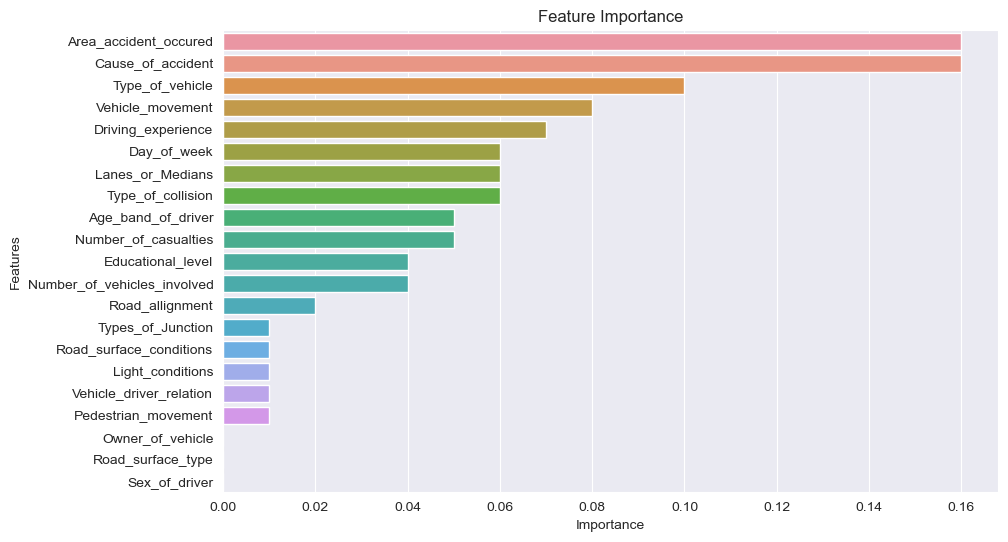

In [8]:
plt.figure(figsize = (10, 6))
sns.barplot(x = aggregated_features["importance"], y = aggregated_features.index).set(title = "Feature Importance", xlabel = "Importance", ylabel = "Features");

In [11]:
ada_feature = aggregated_features.index[:12].tolist()
eta_new = eta[ada_feature]
eta_new.head()

,Area_accident_occured,Cause_of_accident,Type_of_vehicle,Vehicle_movement,Driving_experience,Day_of_week,Lanes_or_Medians,Type_of_collision,Age_band_of_driver,Number_of_casualties,Educational_level,Number_of_vehicles_involved
1,Office areas,Overtaking,Public (> 45 seats),Going straight,Above 10yr,Monday,Undivided Two way,Vehicle with vehicle collision,31-50,2,Junior high school,2
3,Office areas,Changing lane to the right,Public (> 45 seats),Going straight,5-10yr,Sunday,other,Vehicle with vehicle collision,18-30,2,Junior high school,2
7,Residential areas,No priority to vehicle,Automobile,U-Turn,2-5yr,Friday,other,Vehicle with vehicle collision,18-30,1,Junior high school,2
8,Industrial areas,Changing lane to the right,Lorry (41?100Q),Going straight,Above 10yr,Friday,other,Collision with roadside-parked vehicles,18-30,1,Junior high school,2
9,Residential areas,Moving Backward,Automobile,U-Turn,1-2yr,Friday,Undivided Two way,Collision with roadside-parked vehicles,18-30,1,Junior high school,2


In [13]:
categorical_new = [col for col in eta_new.columns]
categorical_new.remove("Number_of_vehicles_involved")
categorical_new.remove("Number_of_casualties")
numerical_new = ["Number_of_vehicles_involved", "Number_of_casualties"]

### Part 3. Explanatory Data Analysis

##### (a) Descriptive Statistics

##### (b) Data Visualization

##### (c) Correlation Analysis

##### (d) Dimensionality Reduction by PCA

##### (e) Cluster Analysis by Hierarchical Clustering

### Part 4. Data Spliting

In [14]:
standard = StandardScaler()
eta_new[numerical_new] = standard.fit_transform(eta_new[numerical_new])
X = pd.get_dummies(eta_new, columns = categorical_new, drop_first = True)
y = y_ada

C:\Users\26447\AppData\Local\Temp\ipykernel_20104\2644754573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eta_new[numerical_new] = standard.fit_transform(eta_new[numerical_new])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state = 233)

### Part 5. Model Selection
#### (a) SVM

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'C': 100, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, degree=1, gamma=1)
Accuracy score:  0.9183325584999226
Classification report:                  precision    recall  f1-score   support

  Fatal injury       0.99      0.99      0.99      2169
Serious Injury       0.98      0.78      0.87      2164
 Slight Injury       0.81      0.99      0.89      2120

      accuracy                           0.92      6453
     macro avg       0.93      0.92      0.92      6453
  weighted avg       0.93      0.92      0.92      6453



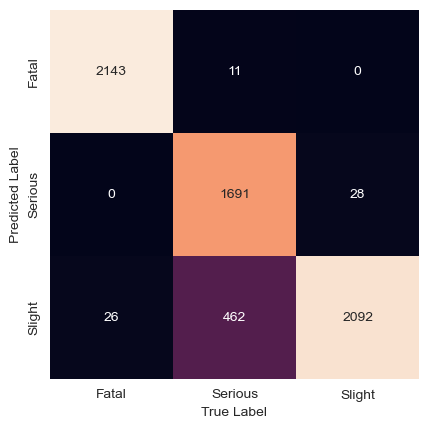

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
param_svc = {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001], "kernel": ["rbf", "linear", "poly", "sigmoid"], "degree": [1, 2, 3, 4]}
svc = GridSearchCV(SVC(), param_svc, refit = True, verbose = 1, n_jobs = 12)
svc.fit(X_train, y_train)
print(svc.best_params_)
print(svc.best_estimator_)
y_pred = svc.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True Label")
plt.ylabel("Predicted Label");

#### (b) Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
param_gbc = {"learning_rate": [0.1, 0.01, 0.001], "n_estimators": [100, 200, 300], "max_depth": [1, 2, 3, 4, 5]}
gbc = GridSearchCV(GradientBoostingClassifier(), param_gbc, refit = True, verbose = 1, n_jobs = 12)
gbc.fit(X_train, y_train)
print(gbc.best_params_)
print(gbc.best_estimator_)
y_pred = gbc.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True Label")
plt.ylabel("Predicted Label");

#### (c) Multilayer Perceptron

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 100, 100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'sgd'}
MLPClassifier(alpha=0.05, hidden_layer_sizes=(100, 100, 100, 100, 100),
              learning_rate='adaptive', solver='sgd')
Accuracy score:  0.903300790330079
Classification report:                  precision    recall  f1-score   support

  Fatal injury       0.98      0.99      0.99      2169
Serious Injury       0.90      0.82      0.86      2164
 Slight Injury       0.83      0.90      0.87      2120

      accuracy                           0.90      6453
     macro avg       0.90      0.90      0.90      6453
  weighted avg       0.90      0.90      0.90      6453



c:\Users\26447\anaconda3\envs\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


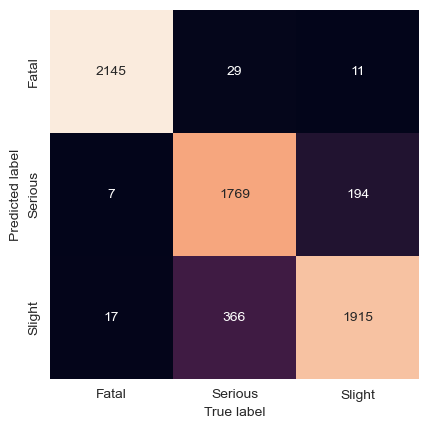

In [21]:
from sklearn.neural_network import MLPClassifier
param_mlp = {"hidden_layer_sizes": [(100, 100, 100), (100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)], "activation": ["relu", "logistic"], "solver": ["adam", "sgd"], "alpha": [0.0001, 0.05], "learning_rate": ["constant", "adaptive"]}
mlp = GridSearchCV(MLPClassifier(), param_mlp, refit = True, verbose = 1, n_jobs = 12)
mlp.fit(X_train, y_train)
print(mlp.best_params_)
print(mlp.best_estimator_)
y_pred = mlp.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True label")
plt.ylabel("Predicted label");

#### (d)

### Part 6. Model Evaluation

In [23]:
models = pd.DataFrame({
    "Model": ["Support Vector Machine", "Gradient Boosting", "Multilayer Perceptron"],
    "Accuracy": [accuracy_score(y_test, svc.predict(X_test)), accuracy_score(y_test, gbc.predict(X_test)), accuracy_score(y_test, mlp.predict(X_test))]})
models.sort_values(by = "Accuracy", ascending = False)

,Model,Accuracy
0,Support Vector Machine,0.918333
2,Multi-layer Perceptron,0.903301
1,Random Forest,0.883155


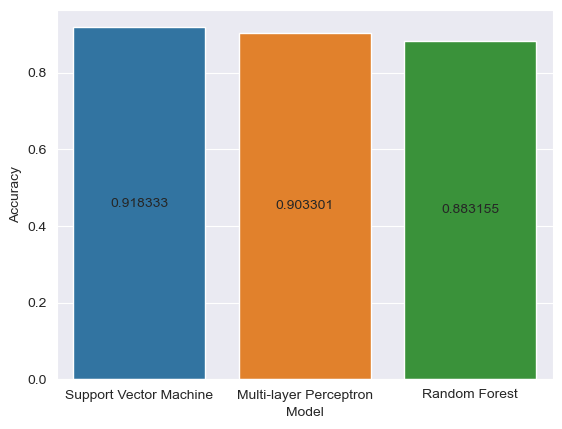

In [24]:
ax = sns.barplot(x = "Model", y = "Accuracy", data = models.sort_values(by = "Accuracy", ascending = False))
for acc in ax.containers:
    ax.bar_label(acc, label_type = "center");